In [1]:
pip install -q "tensorflow-text==2.8.*"

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

2022-04-23 13:42:51.324335: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-23 13:42:51.324401: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
#Open data
data_file = open('Data.txt').read()
data_file

#Create tokenizer object
tokenizer = Tokenizer()

#Convert data to lowercase
data = data_file.lower().split('.')
data

[' the important thing is not to stop questioning',
 ' curiosity has its own reason for existence',
 ' one cannot help but be in awe when he contemplates the mysteries of eternity, of life, of the marvelous structure of reality',
 ' it is enough if one tries merely to comprehend a little of this mystery each day',
 '']

In [4]:
###Add start stop tokens###
start_token = '<start>'
end_token = ' <end>'

for sentence in range(len(data)) :
    data[sentence] = start_token + data[sentence]
    
for sentence in range(len(data)) :
    data[sentence] = data[sentence] + end_token
    
data

['<start> the important thing is not to stop questioning <end>',
 '<start> curiosity has its own reason for existence <end>',
 '<start> one cannot help but be in awe when he contemplates the mysteries of eternity, of life, of the marvelous structure of reality <end>',
 '<start> it is enough if one tries merely to comprehend a little of this mystery each day <end>',
 '<start> <end>']

In [5]:
def Encode_Inputs(data, max_sentence_length):
    #Create dictionary of words with the frequency they occur
    #Every word gets unique value > 0
    #0 is reserved for padding
    tokenizer.fit_on_texts(data)

    #Transforms sentences into set of integers from the dictionary
    input_sequences = tokenizer.texts_to_sequences(data)

    #Pad sequences to length of max_length
    input_sequences = tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen = max_sentence_length, padding ='post', value = 0)

    #Counts total words
    total_words = len(tokenizer.word_index) + 1
    #input_sequences = np.delete(input_sequences, 4, axis=0)
    
    return input_sequences, total_words

In [6]:
def Decode_Inputs(input_sequences):
    data = tokenizer.sequences_to_texts(input_sequences)
    return data

In [7]:
def Create_Output_Sequences(input_sequences):
    #Shift array by one to create targets
    #Last item is all 0s because it is not used
    roll_amount = input_sequences.shape[1] * (input_sequences.shape[0]-1)
    output_sequences = np.array(np.roll(input_sequences, roll_amount))
    output_sequences[-1] = 0

    return output_sequences

In [8]:
class Transformer_Block(keras.layers.Layer):
    def __init__(self, num_heads, embed_dim, ff_dim, dropout):
        super(Transformer_Block, self).__init__()
        self.attention = keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
        self.layer_norm1 = keras.layers.LayerNormalization(epsilon = 1e-6)
        self.feed_forward = keras.Sequential([keras.layers.Dense(ff_dim, activation = "gelu"), keras.layers.Dense(embed_dim)])
        self.layer_norm2 = keras.layers.LayerNormalization(epsilon = 1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(dropout)
        self.dropout2 = keras.layers.Dropout(dropout)
        
    def call(self, embedded_words, training):
        attention_output = self.attention(embedded_words, embedded_words)
        attention_output = self.dropout1(attention_output, training=training)
        #Residual connections from input to add/norm
        res1 = self.layer_norm1(embedded_words + attention_output)
        ffn_output = self.feed_forward(res1)
        ffn_output = self.dropout2(ffn_output, training=training)
        #Residual connections from add/norm to add/norm
        final_output = self.layer_norm2(ffn_output + res1)
        return final_output

In [9]:
class MaskedTransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(MaskedTransformerBlock, self).__init__()
        self.att1 = keras.layers.MultiHeadAttention(num_heads=num_heads,
        key_dim=embed_dim)
        self.att2 = keras.layers.MultiHeadAttention(num_heads=num_heads,
        key_dim=embed_dim)
        self.ffn = keras.Sequential(
        [keras.layers.Dense(ff_dim, activation="gelu"),
        keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)
        
    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, inputs, training):
        input_shape = tf.shape(inputs[0])
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        mask = self.causal_attention_mask(batch_size,
        seq_len, seq_len,
        tf.bool)
        attn_output1 = self.att1(inputs[0], inputs[0],
        attention_mask = mask)
        attn_output1 = self.dropout1(attn_output1, training=training)
        out1 = self.layernorm1(inputs[0] + attn_output1)
        attn_output2 = self.att2(out1, inputs[1])
        attn_output2 = self.dropout2(attn_output2, training=training)
        out2 = self.layernorm1(out1 + attn_output2)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        return self.layernorm2(out2 + ffn_output)

In [10]:
class MaskedTokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(MaskedTokenAndPositionEmbedding, self).__init__()
        self.token_emb = keras.layers.Embedding(input_dim=vocab_size,
        output_dim=embed_dim,
        mask_zero=True)
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen+1,
        output_dim=embed_dim,
        mask_zero=True)
 
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=1, limit=maxlen+1, delta=1)
        positions = positions * tf.cast(tf.sign(x),tf.int32)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [11]:
#Pool encoder output with existing context matrix
class Multi_Head_Attention_Pooling(keras.layers.Layer):
    def __init__(self, num_heads, embed_dim, dropout):
        super(Multi_Head_Attention_Pooling, self).__init__()
        self.attention = keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
        
    #Pass in encoder as input[0], context matrix as input[1]
    def call(self, input_data):
        attention_output = self.attention(input_data[0], input_data[1])
        self_attention_output = self.attention(attention_output, attention_output)
        pooled_context = self_attention_output
        return pooled_context

In [12]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def MaskedSparseCategoricalCrossentropy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
def MaskedSparseCategoricalAccuracy(real, pred):
    accuracies = tf.equal(tf.cast(real,tf.int64), tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)

In [13]:
max_sentence_length = 20

input_sequences, total_words = Encode_Inputs(data, max_sentence_length)
print(total_words)
print(input_sequences.shape)
print(input_sequences)

decoded = Decode_Inputs(input_sequences)
decoded

47
(5, 20)
[[ 1  4  8  9  5 10  6 11 12  2  0  0  0  0  0  0  0  0  0  0]
 [ 1 13 14 15 16 17 18 19  2  0  0  0  0  0  0  0  0  0  0  0]
 [22 23 24 25 26 27 28  4 29  3 30  3 31  3  4 32 33  3 34  2]
 [ 1 35  5 36 37  7 38 39  6 40 41 42  3 43 44 45 46  2  0  0]
 [ 1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


['start the important thing is not to stop questioning end',
 'start curiosity has its own reason for existence end',
 'but be in awe when he contemplates the mysteries of eternity of life of the marvelous structure of reality end',
 'start it is enough if one tries merely to comprehend a little of this mystery each day end',
 'start end']

In [14]:
output_sequences = Create_Output_Sequences(input_sequences)
print(output_sequences.shape)
print(output_sequences)

decoded = Decode_Inputs(output_sequences)
decoded

(5, 20)
[[ 1 13 14 15 16 17 18 19  2  0  0  0  0  0  0  0  0  0  0  0]
 [22 23 24 25 26 27 28  4 29  3 30  3 31  3  4 32 33  3 34  2]
 [ 1 35  5 36 37  7 38 39  6 40 41 42  3 43 44 45 46  2  0  0]
 [ 1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


['start curiosity has its own reason for existence end',
 'but be in awe when he contemplates the mysteries of eternity of life of the marvelous structure of reality end',
 'start it is enough if one tries merely to comprehend a little of this mystery each day end',
 'start end',
 '']

In [15]:
#Variables
embed_dim = 512
data = input_sequences
training = True
total_words = total_words
max_sentence_length = max_sentence_length
num_heads = 8 
ff_dim = 16
dropout = 0.15
num_seeds = 32

encoder_stack = 1
decoder_stack = 1

#Initialize context matrix
context = tf.random.uniform(shape=(1, num_seeds, embed_dim))

2022-04-23 13:42:54.783216: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-23 13:42:54.783281: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-23 13:42:54.783327: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-klg6z): /proc/driver/nvidia/version does not exist
2022-04-23 13:42:54.783771: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


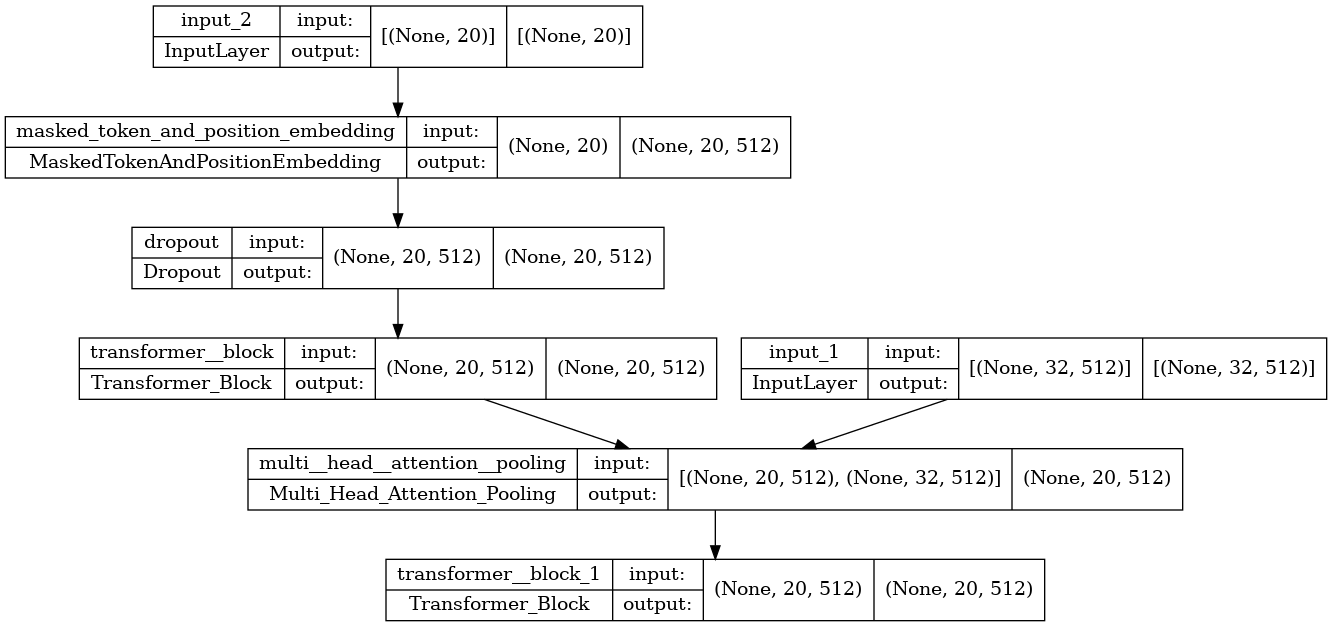

In [16]:
#Encoder

#Create layer for context
context_input_layer_encoder = keras.layers.Input(shape=context.shape[1:])

#Sequence input
input_layer = keras.layers.Input(shape=input_sequences.shape[1])
position_embedding_layer =  MaskedTokenAndPositionEmbedding(input_sequences.shape[1], total_words, embed_dim)(input_layer)

#Dropout
dropout = keras.layers.Dropout(dropout,noise_shape=position_embedding_layer.shape[:-1]+(1,))(position_embedding_layer)
encoder = dropout

for i in range(encoder_stack):
    encoder = Transformer_Block(num_heads, embed_dim, ff_dim, dropout)(encoder)

input_context_pooling_layer = Multi_Head_Attention_Pooling(num_heads, embed_dim, dropout)([encoder, context_input_layer_encoder])
                                                                                                  
encoder = Transformer_Block(num_heads, embed_dim, ff_dim, dropout)(input_context_pooling_layer)

encoder_model = keras.Model([input_layer, context_input_layer_encoder], encoder, name='Encoder')
keras.utils.plot_model(encoder_model,show_shapes=True,expand_nested=True)

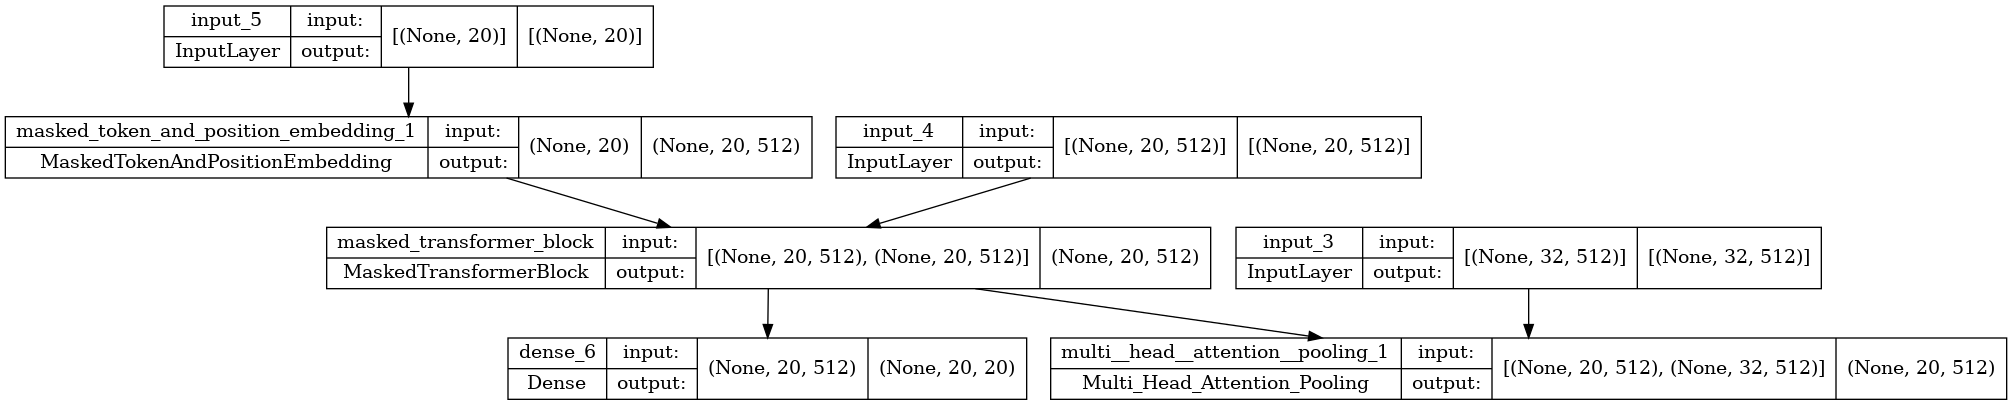

In [17]:
#Decoder 

#Context input_layer
context_input_layer_decoder = keras.layers.Input(shape=context.shape[1:])

#Encoder output (input)
encoder_input_layer = keras.layers.Input(shape = encoder_model.output_shape[1:])

#Decoder target input
input_layer = keras.layers.Input(shape = output_sequences.shape[1])
position_embedding_layer = MaskedTokenAndPositionEmbedding(output_sequences.shape[1], total_words, embed_dim)(input_layer)
decoder = position_embedding_layer

for i in range(decoder_stack):
    decoder = MaskedTransformerBlock(embed_dim, num_heads, ff_dim, dropout)([decoder, encoder_input_layer])
    
linear_layer = keras.layers.Dense(max_sentence_length)(decoder)

#Output of decoder/linear layer? should go to update context matrix with pooling
context = Multi_Head_Attention_Pooling(num_heads, embed_dim, dropout)([decoder, context_input_layer_decoder])

decoder_model = keras.Model([input_layer, encoder_input_layer, context_input_layer_decoder], [linear_layer, context])
keras.utils.plot_model(decoder_model,show_shapes=True,expand_nested=True)

In [18]:
decoder_model.input_shape[2][:3]

(None, 32, 512)

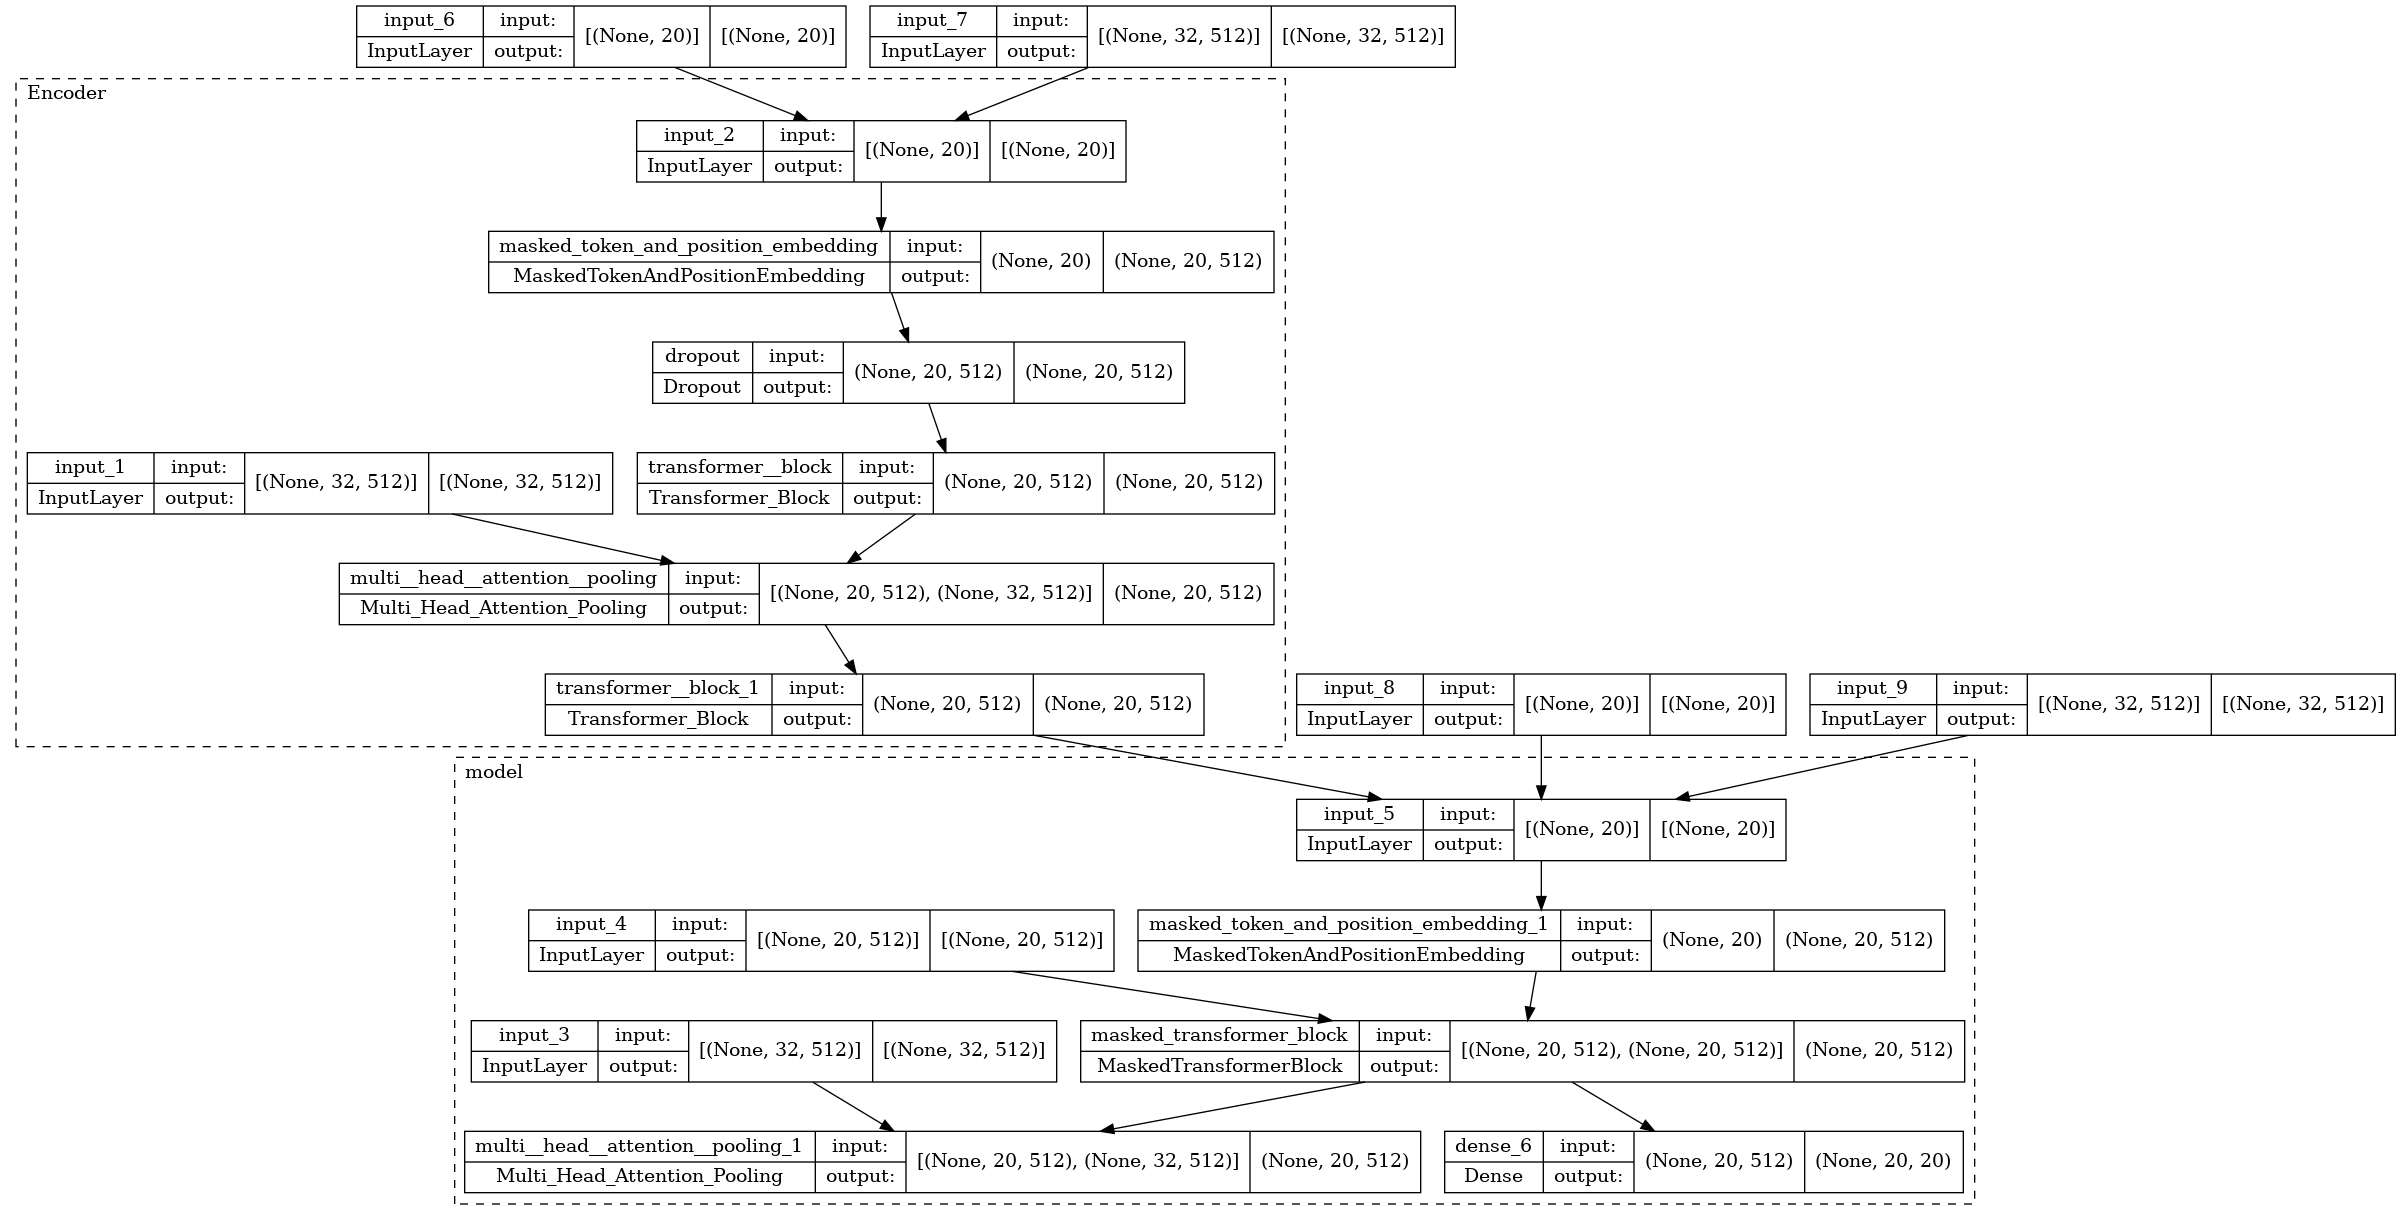

In [19]:
sequences = keras.layers.Input(encoder_model.input_shape[0][1:])
context = keras.layers.Input(encoder_model.input_shape[1][1:])
targets = keras.layers.Input(decoder_model.input_shape[0][1:])
context_decoder = keras.layers.Input(decoder_model.input_shape[2][1:])



transformer = decoder_model([targets, encoder_model([sequences, context]), context_decoder])
transformer = keras.Model([sequences, context_decoder, targets, context], transformer)


keras.utils.plot_model(transformer,show_shapes=True,expand_nested=True)